# Parte 03

Nessa parte vamos trabalhar com um cenário mais complexo. Em particular, iremos treinar um conjunto de modelos [Arima](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). O conjunto de dados que utilizaremos é uma matriz multidimensional com 5 dimensões: **(grupo-série, instante-de-tempo, localização-x, localização-y, valor)**. Note que para cada tripla distinta **(grupo-de-série, localização-x, localização-y)** há uma série temporal com a temperatura em 10 instantes de tempo. Dito isto, os modelos a serem treinados predirão o décimo instante de tempo a partir dos nove anteriores.

Como no exemplo anterior, também particionaremos o conjunto de dados. Entretanto, nesse caso particionamos o dataset ao longo das dimensões localização-x e localização-y.

In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import seaborn as sns
import tensorflow as tf
import os

# Reprodutibilidade
import numpy as np
import random as rn
import tensorflow as tf

seed = 32
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Necessário mudar o diretório de trabalho para o nível mais acima
if not 'notebooks' in os.listdir('.'):
    current_dir = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)

from src.model import Arima, ModelFactory
from src.util import plot_heatmap, temporal_train_val_test2, factor_number


sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Paired"))

tf.get_logger().setLevel('ERROR')

In [2]:
# Carregamento do dataset de temperatura

dataset_path = 'data/tiny-dataset.hdf5'

with h5py.File(dataset_path, 'r') as in_:
    data = in_['real'][...]
    
print('Shape:', data.shape)

Shape: (400, 10, 35, 40, 1)


In [3]:
# O dataset de temperatura é dividido em x (primeiros 9 instantes) e y (último instante).
x = data[:, :-1]
y = data[:, 1:]

num_models = 25
test_size = .2
val_size = .3

# Indica quais dimensões devem servir para o particionamento (localização-x e localização-y)
split_axis = (2, 3)

model_name_prefix = 'arima'
output_dir = os.path.join(parent_dir, 'saved_models_arima')

**Na célula abaixo é instanciada uma fábrica de modelos. A fábrica ('model_factory') ficará responsável por:**
1. Efetuar a partição de x ao longo das dimensões de localização.
3. Treinar cada modelo na sua devida partição;
4. Treinar um modelo em todo o domínio;
5. Salvar os modelos;
6. Salvar os dados.

In [4]:
model_config = dict(u=0, optimizer=tf.keras.optimizers.RMSprop(),
                    early_stopping_min_delta=1e-8,early_stopping_patience=30,epochs=150)

model_factory = ModelFactory(model_class=Arima, x=x, f_x=y, num_models=num_models,
                             test_size=test_size, val_size=val_size,
                             model_name_prefix=model_name_prefix,
                             model_kwargs=model_config,
                             train_val_test_splitter=temporal_train_val_test2,
                             x_split_axis=split_axis, y_split_axis=split_axis)

In [5]:
model_factory.build_models()
model_factory.fit_models()

Building models: 100%|██████████| 25/25 [00:00<00:00, 186.80it/s]
Training models by partition: 25it [02:38,  6.34s/it]
Training a model in the whole domain: 100%|██████████| 1/1 [00:49<00:00, 49.69s/it]


In [6]:
info = model_factory.get_metric_info()

model_factory.save_models(output_dir)
model_factory.save_data(output_dir, info)

Building metric matrices: 26it [00:35,  1.35s/it]


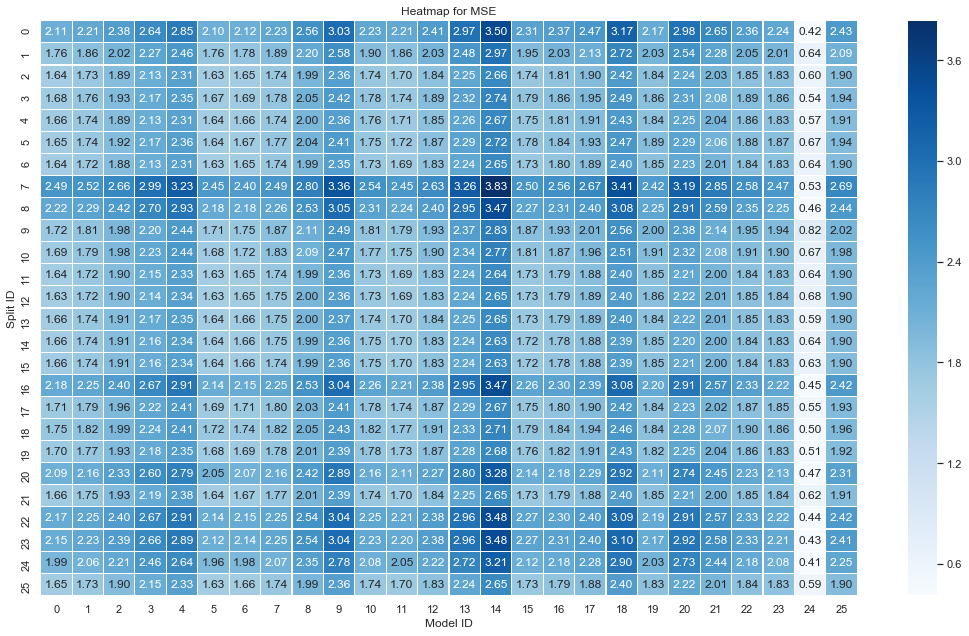

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

matrix = info['mean_absolute_error']

plot_heatmap(matrix=matrix, title=f'Heatmap for MSE', x_label='Model ID', y_label='Split ID', ax=ax,
             heatmap_kwargs=dict(linewidths=.1, cmap='Blues', annot=True, fmt='.2f'))
fig.tight_layout()